# Car-mpg

In [460]:
using Plots, PyCall, PyPlot
@pyimport seaborn as sns
@pyimport pandas as pd

## Carmpg dataset

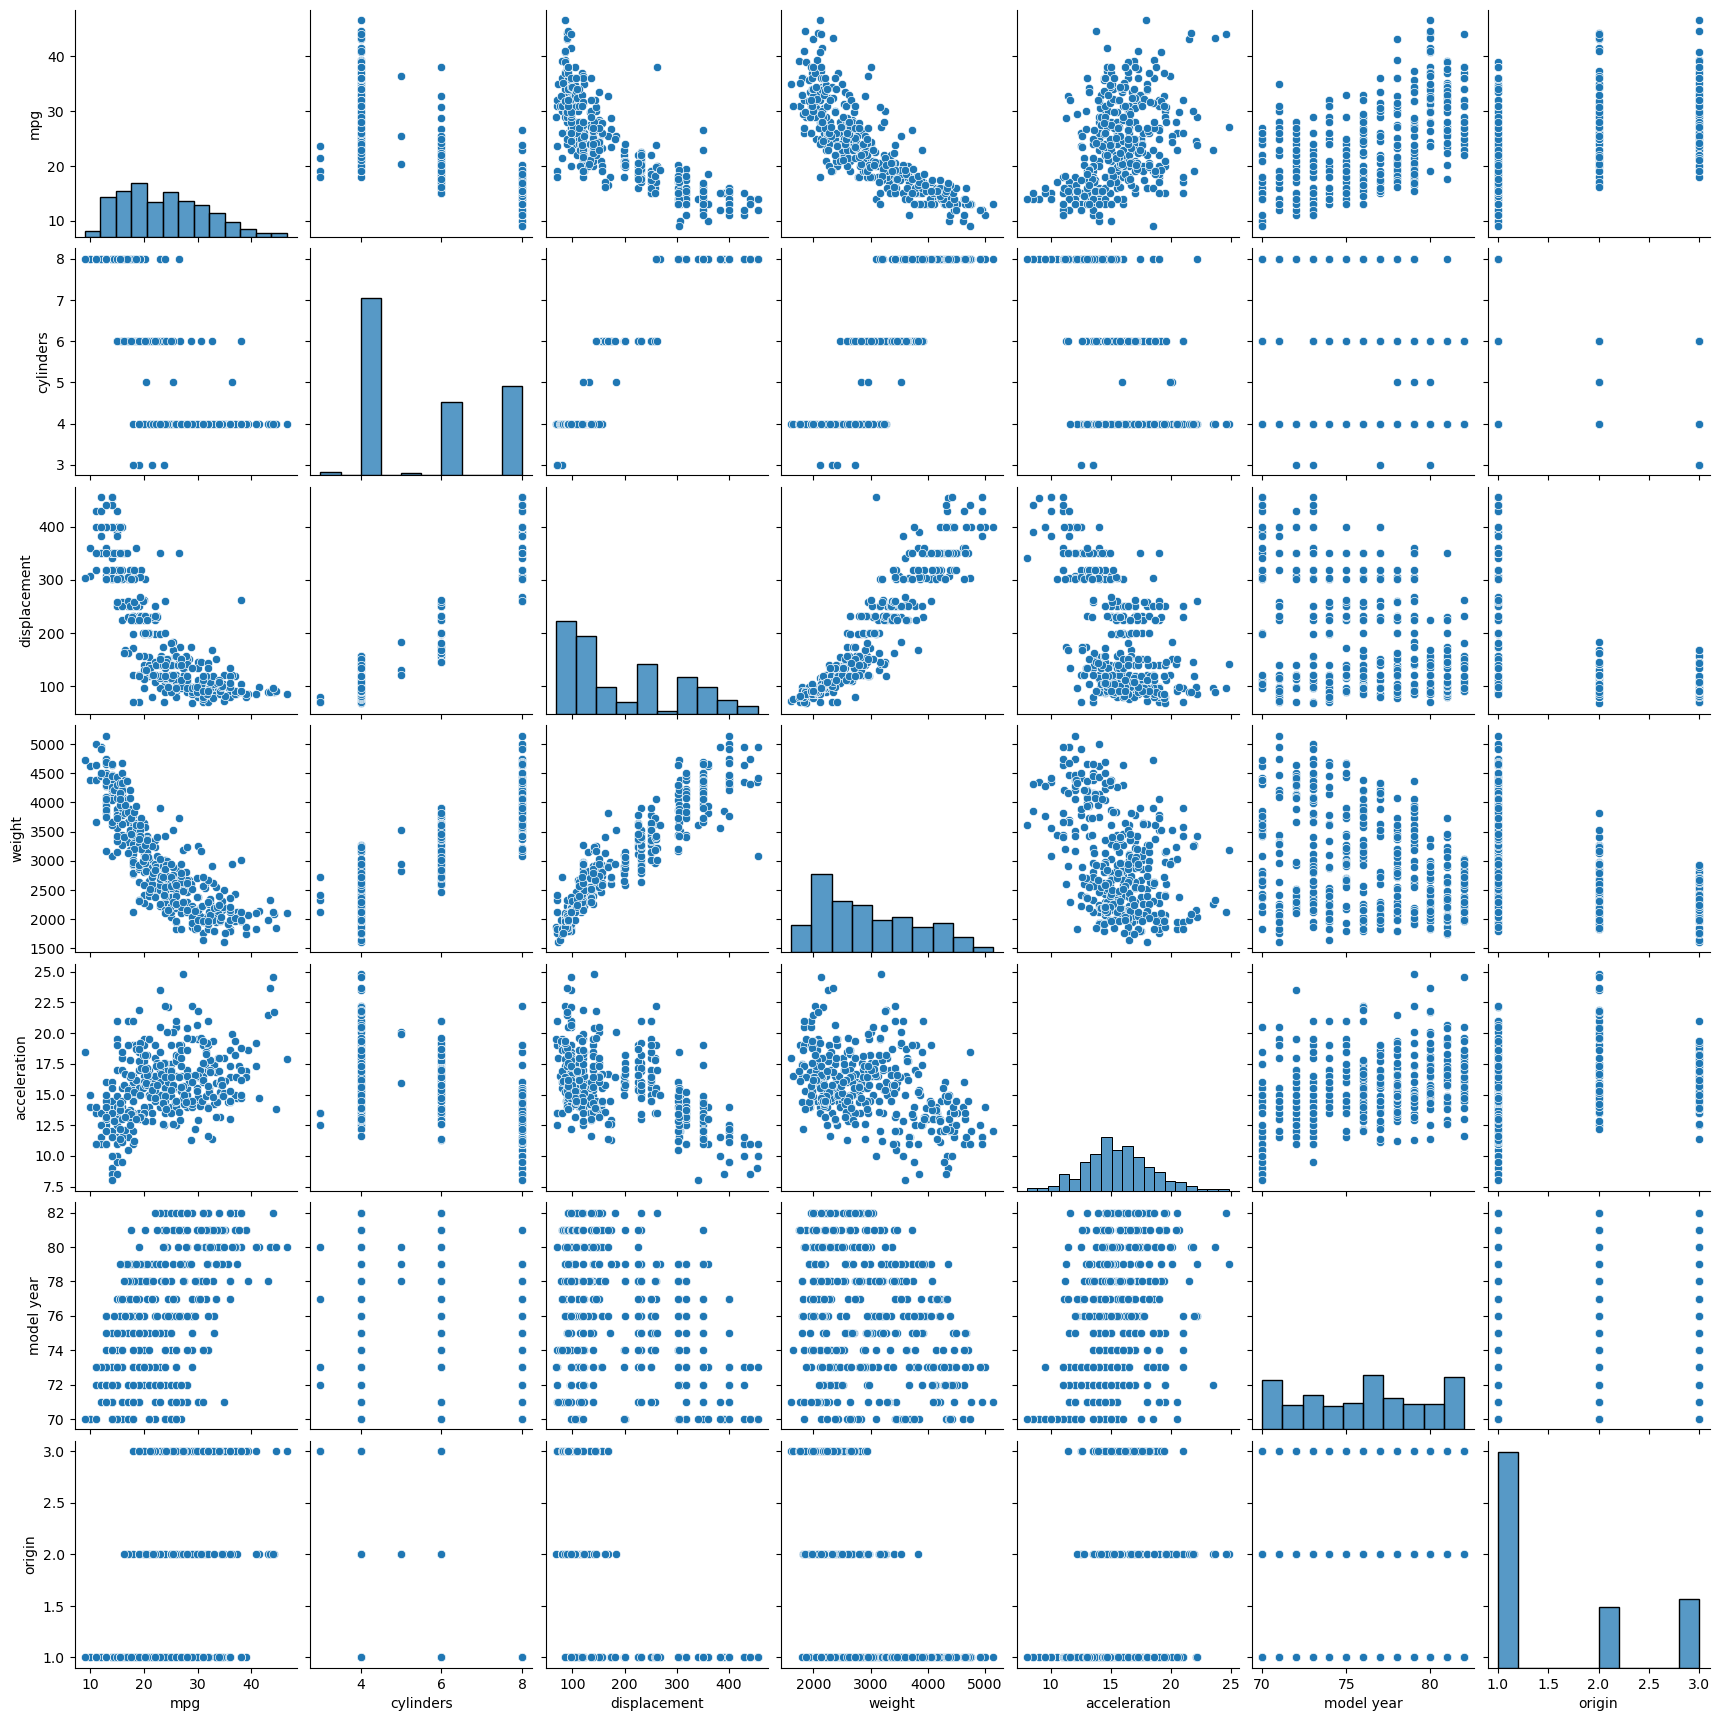

PyObject <seaborn.axisgrid.PairGrid object at 0x7f3e010f9880>

In [302]:
df = pd.read_csv("../Datasets/auto-mpg.csv")
sns.pairplot(df)

## 可以看到，cylinders 和 origin  这两个分类变量对应变量mpg是有影响的，考虑到样本容量只有392，这里将类别较少的 origin 放入模型；

## 连续变量则考虑 displacement, weight, acceleration, horsepower，

## $x_3$为acceleration，从图形看是一个噪声

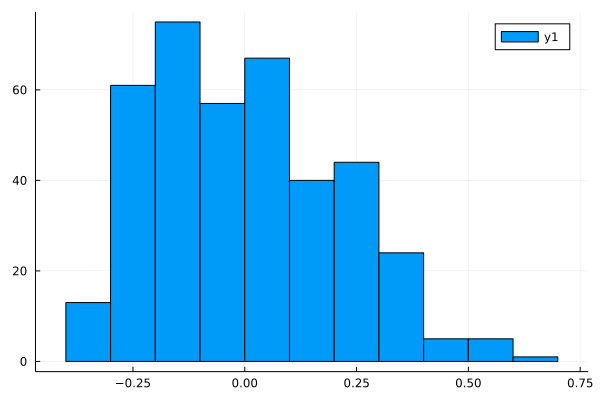

In [734]:
## data pre-process"
include("RealWorldData.ji")

X, Z, y, zmap = get_cardata()
Hy = maximum(y) - minimum(y) 
y = y ./Hy
y = y .- mean(y)

histogram(y)

这里对y进行了放缩，实验中发现如果不这么做离散项的估计就很差；

应该是因为$\gamma$的估计方法，其要求$z$取不同值时, 对应的函数曲线距离不能太大

In [501]:
zmap

1-element Vector{Any}:
 Dict{Any, Any}(2 => [0, 0], 3 => [0, 1], 1 => [1, 0])

origin 的三个不同取值的映射

## PLSIQR fitting

In [773]:

width_exp = -0.2

nfold = 4
index_test, index_train = nsplit_z(Z, nfold)
Alpha = []
Theta = []
Beta = []
Gamma = []
for k in 1:nfold
    indt, indr = index_test[k], index_train[k]
    Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr] 
    Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]
    carmodel = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
    qgplsim.estimator(carmodel)
    qgplsim.print_model(carmodel)
    vv = Xt * carmodel.theta + Zt * carmodel.gamma
    ylx = Xt * carmodel.alpha
    ylz = Zt * carmodel.beta
    gv = qgplsim.predict(carmodel, Xt, Zt)
    yp = (gv + ylx + ylz)
    push!(Alpha, carmodel.alpha)
    push!(Beta, carmodel.beta)
    push!(Theta, carmodel.theta)
    push!(Gamma, carmodel.gamma)
    println("rmse of fold $k: ", rmsd(yp, yt) * Hy, "\n")
end



alpha => [-0.0676, -0.1086, 0.0354, 0.0533]
theta => [0.6574, -0.1945, 0.7266, -0.0446]
gamma => [0.512, 0.1782]
beta => [0.0196, 0.0163]
rmse of fold 1: 2.7487652464212493

alpha => [-0.0128, -0.0695, -0.061, 0.0137]
theta => [0.9432, -0.0028, -0.245, -0.2243]
gamma => [0.09, 0.0485]
beta => [0.0231, 0.0257]
rmse of fold 2: 3.2790238969217724

alpha => [-0.0209, -0.0818, -0.0614, 0.0346]
theta => [0.9695, -0.1289, -0.1971, -0.0674]
gamma => [0.0175, 0.0764]
beta => [0.0297, 0.0998]
rmse of fold 3: 3.642204219134563

alpha => [-0.0362, -0.0674, -0.0734, 0.0401]
theta => [0.9341, -0.2137, -0.284, -0.0352]
gamma => [-0.0017, -0.0235]
beta => [-0.0042, 0.0175]
rmse of fold 4: 3.7570191307789567



In [774]:
alpha_, theta_, beta_, gamma_ = mean(Alpha), mean(Theta), mean(Beta), mean(Gamma)
car_model = qgplsim.model(X, Z, y, [0.5], width_exp)
car_model.alpha, car_model.theta, car_model.beta, car_model.gamma = alpha_, theta_, beta_, gamma_ 
vv = X * car_model.theta + Z * car_model.gamma
ylx = X * car_model.alpha
ylz = Z * car_model.beta
gv = qgplsim.predict(car_model, X, Z)
yp = gv + ylx + ylz  
rmsd(yp, y) * Hy

3.1371536942462757

## 单次实验，测试集预测的结果与真实值的对比

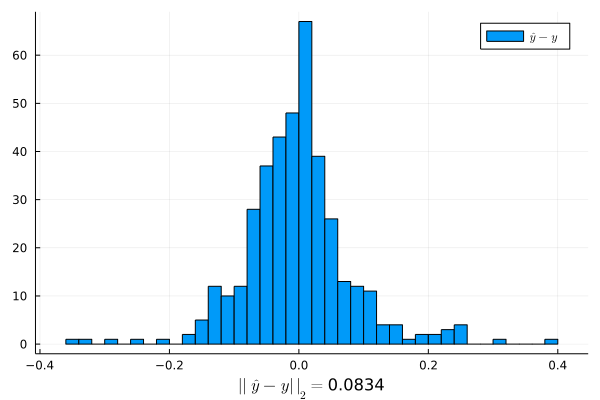

In [775]:
using LaTeXStrings
e = round(rmsd(yp, y), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$e")
histogram(y .- yp, label = L"\hat{y} - y")
xlabel!(str)

## 分类变量$z_i$, $i = 1,2,3$， 非参部分估计的在$q = 0.5$时的拟合曲线

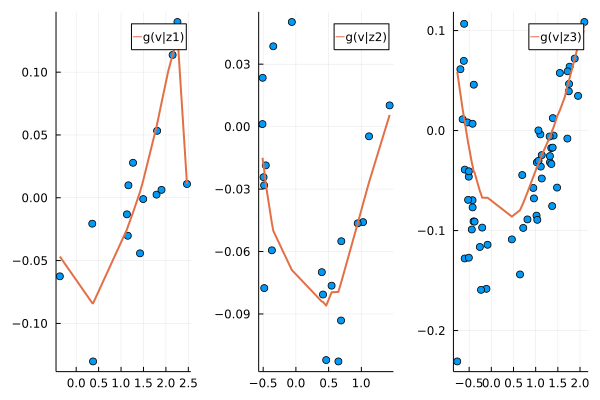

In [776]:
fig = plot(layouts = (1,3))
categ, index = collection(Zt)
for k in 1:3
    pk = fig.subplots[k]
    zk = categ[k]
    indk = index[zk]
    
    vk = vv[indk]   
    ypk = gv[indk]   
    ytk = y[indk] - ylx[indk] - ylz[indk]

    sort_ind = sortperm(vk)

    scatter!(pk, vk, ytk, label = false)
    plot!(pk, vk[sort_ind], ypk[sort_ind], width = 2, label = "g(v|z$k)")

end
fig

## Monte Carlo: compared with a semi-mave method from Xia. (2006) 

In [777]:
include("./src/semi_mave.ji")
include("./src/qgplsim.ji")

n_repeat = 50
nfold = 4
Alpha = []
Theta = []
Beta = []
Gamma = []
width_exp = -0.2
@threads for t in 1:4
    for k in 1:n_repeat

        index_test, index_train = nsplit_z(Z, nfold)
        alpha = []
        theta = []
        beta = []
        gamma = []
        for k in 1:nfold
            indt, indr = index_test[k], index_train[k]
            Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr] 
            Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]
            carmodel = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
            qgplsim.estimator(carmodel)

            push!(alpha, carmodel.alpha)
            push!(beta, carmodel.beta)
            push!(theta, carmodel.theta)
            push!(gamma, carmodel.gamma)

        end
        alpha_, theta_, beta_, gamma_ = mean(alpha), mean(theta), mean(beta), mean(gamma)
        push!(Alpha, alpha_)
        push!(Beta, beta_)
        push!(Theta, theta_)
        push!(Gamma, gamma_)


    end
end

┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitq

## 200次蒙特卡洛模拟后各个参数的均值

In [778]:
alpha_, theta_, beta_, gamma_ = mean(Alpha), mean(Theta), mean(Beta), mean(Gamma)
[[:alpha, :theta] [mean(Alpha) mean(Theta)]']

2×5 Matrix{Any}:
 :alpha  -0.0345917  -0.0992401  -0.0426124   0.0421407
 :theta   0.922864   -0.28861    -0.0892709  -0.0848037

In [779]:
[[:beta, :gamma] [mean(Beta) mean(Gamma)]']

2×3 Matrix{Any}:
 :beta   0.0145105  0.0296443
 :gamma  0.0169219  0.00475662

用这个参数做200次预测

In [780]:
rec_rmsd_qr = []
@threads for t in 1:4
    for k in 1:n_repeat
    indr, indt = get_train_index(Z, 196)
    Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr]
    Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]


    car_model = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
    car_model.alpha, car_model.theta, car_model.beta, car_model.gamma = alpha_, theta_, beta_, gamma_ 
    vv = Xt * car_model.theta + Zt * car_model.gamma
    ylx = Xt * car_model.alpha
    ylz = Zt * car_model.beta
    gv = qgplsim.predict(car_model, Xt, Zt)
    yp = gv + ylx + ylz  
    push!(rec_rmsd_qr, rmsd(yp, yt))
    end
end

## PLSIQR做200次实验后 $\sqrt{||\hat{y} - y||_2}$的分布

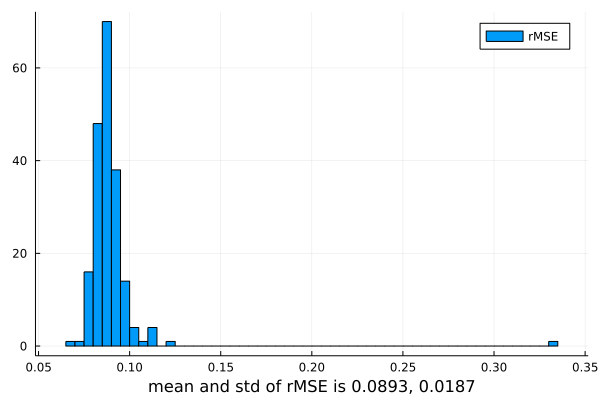

In [781]:
rec_rmsd = rec_rmsd_qr# [ rec_rmsd_qr .< 0.2 ] 
histogram(rec_rmsd, label = "rMSE")
mrmsd = round(mean(rec_rmsd), digits = 4)
std_rmsd = round(std(rec_rmsd), digits = 4)
xlabel!("mean and std of rMSE is $mrmsd, $std_rmsd")

In [782]:
mrmsd * Hy

3.35768

## SEMI-MAVE做200次实验后 $\sqrt{||\hat{y} - y||_2}$的分布

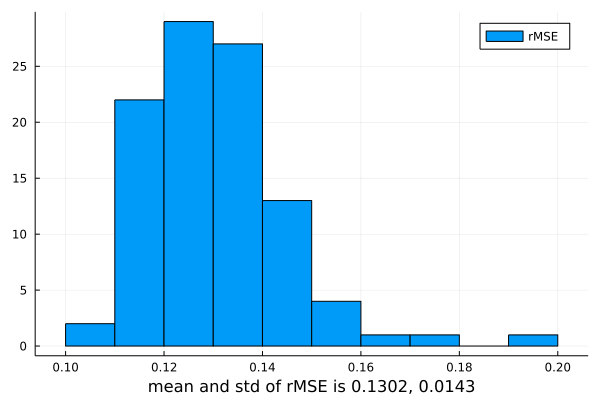

In [476]:
histogram(rec_rmsd_mave, label = "rMSE")
mrmsd_mave = round(mean(rec_rmsd_mave), digits = 4)
std_rmsd_mave = round(std(rec_rmsd_mave), digits = 4)

xlabel!("mean and std of rMSE is $mrmsd_mave, $std_rmsd_mave")

In [477]:
mrmsd_mave * Hy

4.89552

## 总结

在这个数据集的实验中，Xia(2006)的方法对窗宽更敏感，而且经常会出现实验误差很大的情况，如上图；

PLSIQR方法则对窗宽敏感度低，多次蒙特卡洛实验均未出现误差离群的情况；

单纯就这个数据集来说精度上也比夏老师的方法好很多。

#  California Housing

In [225]:
include("./src/supportFunctions.ji")
include("./src/qgplsim.ji")
# include("./src/semi_mave.ji")
include("RealWorldData.ji")
using Plots


In [226]:

Xa, Za, ya = califdata(4.035) # a for all
Z, zmap = categ_binary(Za) # [:, 1]
zmap

2-element Vector{Any}:
 Dict{Any, Any}(2 => [0], 1 => [1])
 Dict{Any, Any}("NEAR BAY" => [1, 0, 0], "INLAND" => [0, 0, 1], "NEAR OCEAN" => [0, 0, 0], "<1H OCEAN" => [0, 1, 0])

## One Single Simulation

In [268]:
Xa, Za, ya = califdata(4.035) # a for all
n = length(ya)

X = scaler(Xa, 1)
y = ya ./(maximum(ya) - minimum(ya)) 
y = y .- mean(y)
Z, zmap = categ_binary(Za) # [:, 1]

ntrain = 1000
ntest = 500
indr, indt = get_train_index(Z, ntrain)

indt = indt[shuffle(1:(n - ntrain))[1:ntest]]
ntest = length(indt)
Xr = X[indr, :]
yr = y[indr] 
Zr = Z[indr, :]

Xt = X[indt, :]
yt = y[indt]  
Zt = Z[indt, :]
sum(Zr, dims = 1)

1×4 Matrix{Float64}:
 420.0  112.0  445.0  314.0

In [269]:
# include("./src/qgplsim.ji")
width_exp = -0.2
dy = 0
method = "qr"
qsmodel = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
qsmodel1 = qgplsim.model(Xr, Zr, yr, [0.1], width_exp)
qsmodel9 = qgplsim.model(Xr, Zr, yr, [0.9], width_exp)


@time qgplsim.estimator(qsmodel)
# @time qgplsim.estimator(qsmodel1)
# @time qgplsim.estimator(qsmodel9)

vv = Xt * qsmodel.theta
ylx = Xt * qsmodel.alpha
ylz = Zt * qsmodel.beta
gv = qgplsim.predict(qsmodel, Xt, Zt, dy, method)
yp = gv + ylx  + ylz

# vv1 = Xt * qsmodel1.theta
# ylx1 = Xt * qsmodel1.alpha
# ylz1 = Zt * qsmodel1.beta
# gv1 = qgplsim.predict(qsmodel1, Xt, Zt, dy, method)
# yp1 = gv1 + ylx1  + ylz1

# vv9 = Xt * qsmodel9.theta
# ylx9 = Xt * qsmodel9.alpha
# ylz9 = Zt * qsmodel9.beta
# gv9 = qgplsim.predict(qsmodel9, Xt, Zt, dy, method)
# yp9 = gv9 + ylx9  + ylz9


qgplsim.print_model(qsmodel)

  1.950753 seconds (10.88 M allocations: 1.025 GiB, 6.55% gc time)
alpha => [0.0317, 0.0268, 0.044]
theta => [0.3466, 0.6696, -0.6569]
gamma => [0.0452, -0.1376, 0.1467, 0.0819]
beta => [0.0318, -0.0251, -0.0344, -0.2074]


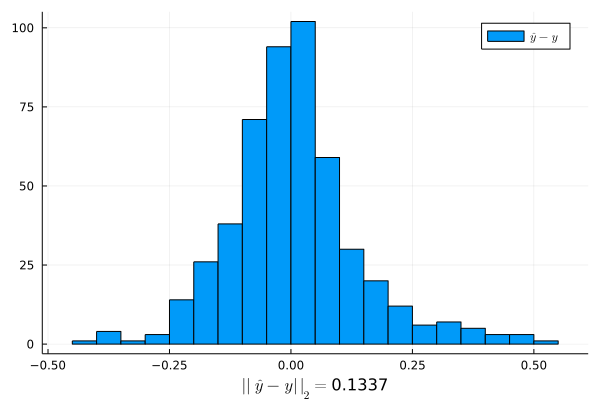

In [270]:
using LaTeXStrings
e = round(rmsd(yp, yt), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$e")
histogram(yt .- yp, label = L"\hat{y} - y")
xlabel!(str)

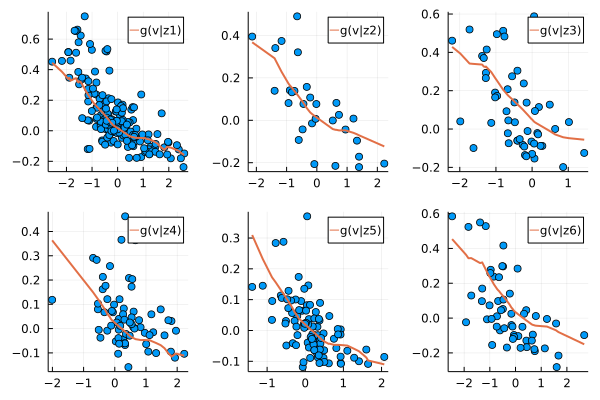

In [272]:
fig = plot(layouts = (2,3))
categ, index = collection(Zt)
for k in 1:6
    pk = fig.subplots[k]
    zk = categ[k]
    indk = index[zk]
    
    vk = vv[indk]
    vk1 = vv1[indk]
    vk9 = vv9[indk]
    
    ypk = gv[indk]
    yp1k = gv1[indk]
    yp9k = gv9[indk]
    
    ytk = yt[indk] - ylx[indk] - ylz[indk]
    ytk1 = yt[indk] - ylx1[indk] - ylz1[indk]
    ytk9 = yt[indk] - ylx9[indk] - ylz9[indk]

    sort_ind = sortperm(vk)
    sort_ind1 = sortperm(vk1)
    sort_ind9 = sortperm(vk9)

    scatter!(pk, vk, ytk, label = false)
    plot!(pk, vk[sort_ind], ypk[sort_ind], width = 2, label = "g(v|z$k)")
    # plot!(pk, vk1[sort_ind1], yp1k[sort_ind1], width = 2, label = "q = 0.1")
    # plot!(pk, -vk9[sort_ind9], yp9k[sort_ind9], width = 2, label = "q = 0.9")

end
fig

In [273]:
include("./src/semi_mave.ji")
car_model_mr = semiMAVE.model(Xr, Zr, yr)
@time semiMAVE.estimator(car_model_mr) 
semiMAVE.print_model(car_model_mr)

 10.807648 seconds (380.80 M allocations: 15.033 GiB, 11.98% gc time, 1.05% compilation time)
theta => [-0.1484, -0.6026, 1.5482]
beta => [-0.0496, -0.1715, -0.219, -0.369]


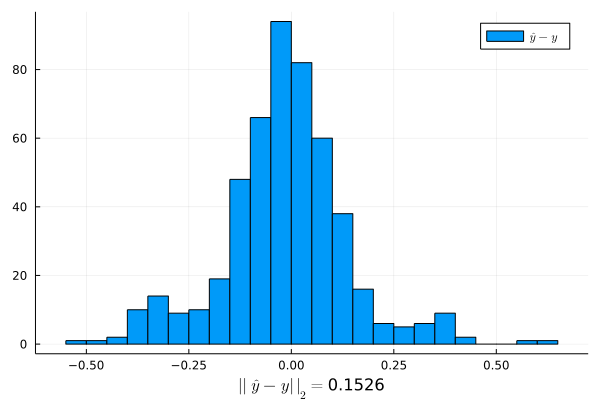

In [274]:
gvm, = semiMAVE.predictor(car_model_mr, Xt, Zt)
ypm = gvm + Zt * car_model_mr.β
em = round(rmsd(ypm, yt), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$em")
histogram(yt .- ypm, label = L"\hat{y} - y")
xlabel!(str)

## 总结


这个数据集样本量太大而且没有精度优势，不过我们的方法因为无迭代，所以在计算时间上快很多（5倍左右）;

很难找到该方法非常适应的数据集，很多情况下和夏老师的方法精度都类似；

似乎我们的方法有更快的速度和更好的鲁棒性？